# Finetune ResNet50


With 1000 x 400 melspectrogram images with online data augmentation (stochastic Gaussian noise), with a lower maximum standard deviation value


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

In [ ]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [ ]:
FINETUNED_MODEL = 'resnet50_augmented_stochastic'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
root_dir = '../../../data/'

Custom dataset class for loading the precomputed tensors of the mel spectrogram images


In [ ]:
from ...datasets.MelspectrogramDataset import MelSpectrogramDataset

Define the training function


In [7]:
def train(model, trainloader, criterion, optimizer, device):
    train_loss = 0.0
    train_total = 0
    train_correct = 0

    # train mode
    model.train()

    epoch_start = time.time()
    pbar = tqdm(enumerate(trainloader), total=len(
        trainloader), desc="training")

    for i, (inputs, labels) in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

        # Calculate time metrics
        elapsed = time.time() - epoch_start
        progress = (i + 1) / len(trainloader)
        eta = elapsed / progress - elapsed

        # Update progress bar with current loss and ETA
        pbar.set_postfix({
            "Loss": f"{loss.item()}",
            "Elapsed": f"{elapsed:.4f}s",
            "ETA": f"{eta:.4f}s"
        })

    train_loss = train_loss / len(trainloader)
    train_accuracy = train_correct / train_total * 100

    return model, train_loss, train_accuracy

Define the testing/evaluation function


In [8]:
def test(model, testloader, criterion, device):
    test_loss = 0.0
    test_total = 0
    test_correct = 0

    # Switch to evaluation mode
    model.eval()

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Update test loss
            test_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(testloader)
    test_accuracy = test_correct / test_total * 100

    return test_loss, test_accuracy

Define what happens in each epoch


In [9]:
def train_epochs(model, trainloader, testloader, criterion, optimizer, device, num_epochs):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    best_accuracy = 0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        epoch_start = time.time()

        model, train_loss, train_accuracy = train(
            model, trainloader, criterion, optimizer, device)
        test_loss, test_accuracy = test(model, testloader, criterion, device)

        epoch_elapsed = time.time() - epoch_start
        print(f"Epoch {epoch+1} completed in {epoch_elapsed:.4f}s")
        print(f'Train Loss: {train_loss} - Train Accuracy: {train_accuracy}')
        print(f'Test Loss: {test_loss} - Test Accuracy: {test_accuracy}')
        print()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # Check if current model is best performing using test_accuracy
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            torch.save(model.state_dict(), f'best_{FINETUNED_MODEL}.pt')
            checkpoint = {
                'epoch': epoch + 1,
                'train_losses': train_losses,
                'train_accuracies': train_accuracies,
                'test_losses': test_losses,
                'test_accuracies': test_accuracies,
            }
            torch.save(checkpoint, f'best_{FINETUNED_MODEL}_checkpoint.pt')

    return model, train_losses, train_accuracies, test_losses, test_accuracies

Plot the loss and accuracy graphs


In [10]:
def plot_loss(train_losses, test_losses):
    plt.figure()
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(test_losses)), test_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [11]:
def plot_accuracy(train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(range(len(train_accuracies)),
             train_accuracies, label='Training Accuracy')
    plt.plot(range(len(test_accuracies)),
             test_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

Define the model


In [12]:
model = models.resnet50(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [13]:
# Number of classes
num_classes = 9

# Freeze all layers except the last fully connected layer
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify final fully connected layer according to number of classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
# print("Modified model")
# print(model)

# Unfreeze the final fully connected layer so it will be trained
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Define a class to add Gaussian noise to the mel spectrogram images for online data augmentation


In [ ]:
from ...data_augmentation.AddGaussianNoiseStochastic import AddGaussianNoiseStochastic

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [15]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define train transformations, also the online data augmentation
train_transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    AddGaussianNoiseStochastic(mean=0.0, std_range=(0.0, 0.03), p=0.5
                               ),  # Online noise augmentation
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

# Define test transformations
test_transform = transforms.Compose([
    # Resize the Mel spectrogram to 224x224, suitable for ResNet50
    transforms.Resize((224, 224)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

epochs = 25

Execute the fine-tuning


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.60it/s, Loss=1.254541039466858, Elapsed=56.8075s, ETA=0.0000s]  


Epoch 1 completed in 80.0665s
Train Loss: 1.4392472194719919 - Train Accuracy: 43.598013415382184
Test Loss: 1.3292529546853267 - Test Accuracy: 48.34982192322912

Epoch 2/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.61it/s, Loss=1.1788326501846313, Elapsed=56.2494s, ETA=0.0000s] 


Epoch 2 completed in 79.4660s
Train Loss: 1.300769015505344 - Train Accuracy: 49.19567067017551
Test Loss: 1.2599675799861099 - Test Accuracy: 50.19390581717451

Epoch 3/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.59it/s, Loss=1.2237709760665894, Elapsed=56.3763s, ETA=0.0000s] 


Epoch 3 completed in 79.9566s
Train Loss: 1.2721458869644358 - Train Accuracy: 49.858525099428164
Test Loss: 1.2621613102729874 - Test Accuracy: 51.03284527107241

Epoch 4/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.64it/s, Loss=1.3517860174179077, Elapsed=56.0760s, ETA=0.0000s] 


Epoch 4 completed in 79.3340s
Train Loss: 1.247758230378356 - Train Accuracy: 51.285146124774926
Test Loss: 1.259915165226869 - Test Accuracy: 50.15433320142462

Epoch 5/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.58it/s, Loss=1.0994161367416382, Elapsed=56.3701s, ETA=0.0000s] 


Epoch 5 completed in 79.8927s
Train Loss: 1.2319929412648647 - Train Accuracy: 52.102336809196856
Test Loss: 1.2225173266247065 - Test Accuracy: 52.314998021369206

Epoch 6/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.61it/s, Loss=1.2543270587921143, Elapsed=56.2961s, ETA=0.0000s] 


Epoch 6 completed in 79.6868s
Train Loss: 1.2176712090456032 - Train Accuracy: 52.56138823482854
Test Loss: 1.1949212201918014 - Test Accuracy: 53.91373169766521

Epoch 7/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.62it/s, Loss=1.2606605291366577, Elapsed=56.3026s, ETA=0.0000s] 


Epoch 7 completed in 79.7148s
Train Loss: 1.2127921382083169 - Train Accuracy: 52.91952749361879
Test Loss: 1.2252806075895675 - Test Accuracy: 52.3229125445192

Epoch 8/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.62it/s, Loss=1.2466440200805664, Elapsed=56.2990s, ETA=0.0000s] 


Epoch 8 completed in 79.7513s
Train Loss: 1.204048910020273 - Train Accuracy: 53.327133500860725
Test Loss: 1.2117409272627397 - Test Accuracy: 52.2437673130194

Epoch 9/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.61it/s, Loss=1.1353358030319214, Elapsed=56.3396s, ETA=0.0000s] 


Epoch 9 completed in 79.7558s
Train Loss: 1.1968069542812396 - Train Accuracy: 53.770355566987874
Test Loss: 1.1739706312767182 - Test Accuracy: 54.713098535813224

Epoch 10/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.61it/s, Loss=1.1157901287078857, Elapsed=56.2933s, ETA=0.0000s] 


Epoch 10 completed in 79.9141s
Train Loss: 1.1892596121075787 - Train Accuracy: 53.978115910484966
Test Loss: 1.1699432116566282 - Test Accuracy: 54.55480807281361

Epoch 11/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.59it/s, Loss=1.2322216033935547, Elapsed=56.4097s, ETA=0.0000s] 


Epoch 11 completed in 79.8230s
Train Loss: 1.1810154679455334 - Train Accuracy: 54.148281525158794
Test Loss: 1.169627465382971 - Test Accuracy: 54.65769687376335

Epoch 12/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.60it/s, Loss=1.032021164894104, Elapsed=56.2994s, ETA=0.0000s]  


Epoch 12 completed in 79.6752s
Train Loss: 1.173550960987429 - Train Accuracy: 54.66471437899444
Test Loss: 1.1833952243881996 - Test Accuracy: 54.230312623664425

Epoch 13/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.62it/s, Loss=1.3193787336349487, Elapsed=56.2612s, ETA=0.0000s] 


Epoch 13 completed in 79.5947s
Train Loss: 1.1705465319790418 - Train Accuracy: 54.62909832010923
Test Loss: 1.1492058321683094 - Test Accuracy: 55.99525128611001

Epoch 14/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.58it/s, Loss=1.2175164222717285, Elapsed=56.4631s, ETA=0.0000s] 


Epoch 14 completed in 79.9202s
Train Loss: 1.1565942448905753 - Train Accuracy: 55.41463028552207
Test Loss: 1.1637570629216203 - Test Accuracy: 55.282944202611795

Epoch 15/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.60it/s, Loss=1.0720365047454834, Elapsed=56.3389s, ETA=0.0000s] 


Epoch 15 completed in 79.8727s
Train Loss: 1.1562430150901215 - Train Accuracy: 55.40275826589367
Test Loss: 1.1675501550086822 - Test Accuracy: 55.148397309062126

Epoch 16/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.61it/s, Loss=1.0552650690078735, Elapsed=56.3265s, ETA=0.0000s] 


Epoch 16 completed in 79.9082s
Train Loss: 1.1495383095137681 - Train Accuracy: 55.49377708304478
Test Loss: 1.1422902935683126 - Test Accuracy: 55.94776414721013

Epoch 17/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.61it/s, Loss=1.0387201309204102, Elapsed=56.3731s, ETA=0.0000s] 


Epoch 17 completed in 79.9089s
Train Loss: 1.1527759286421764 - Train Accuracy: 55.31371811868062
Test Loss: 1.1375677850511339 - Test Accuracy: 55.87653343886031

Epoch 18/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.61it/s, Loss=1.1264511346817017, Elapsed=56.3826s, ETA=0.0000s] 


Epoch 18 completed in 79.6778s
Train Loss: 1.1423441126376768 - Train Accuracy: 55.935020479233856
Test Loss: 1.1381518557818249 - Test Accuracy: 55.67867036011081

Epoch 19/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.61it/s, Loss=1.1616967916488647, Elapsed=56.2557s, ETA=0.0000s] 


Epoch 19 completed in 79.7296s
Train Loss: 1.1397962822189813 - Train Accuracy: 55.90138309028671
Test Loss: 1.131450966753141 - Test Accuracy: 55.615354174910955

Epoch 20/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.57it/s, Loss=1.033944845199585, Elapsed=56.7420s, ETA=0.0000s]  


Epoch 20 completed in 80.2293s
Train Loss: 1.142701238921926 - Train Accuracy: 56.15069550248323
Test Loss: 1.1173495499774664 - Test Accuracy: 56.72338741590819

Epoch 21/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.62it/s, Loss=1.194745421409607, Elapsed=56.3124s, ETA=0.0000s]  


Epoch 21 completed in 80.0183s
Train Loss: 1.1280548577067218 - Train Accuracy: 56.38219988523714
Test Loss: 1.1362438352421076 - Test Accuracy: 56.45429362880886

Epoch 22/25


training: 100%|██████████| 395/395 [00:46<00:00,  8.58it/s, Loss=1.1596719026565552, Elapsed=56.5568s, ETA=0.0000s] 


Epoch 22 completed in 80.0182s
Train Loss: 1.1283178480365608 - Train Accuracy: 56.667128356318884
Test Loss: 1.185831844204604 - Test Accuracy: 54.6418678274634

Epoch 23/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.61it/s, Loss=1.1162368059158325, Elapsed=56.3092s, ETA=0.0000s] 


Epoch 23 completed in 79.6895s
Train Loss: 1.1287544101099425 - Train Accuracy: 56.61370426799106
Test Loss: 1.1636370041153647 - Test Accuracy: 55.844875346260395

Epoch 24/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.59it/s, Loss=1.1258552074432373, Elapsed=56.4491s, ETA=0.0000s] 


Epoch 24 completed in 79.9805s
Train Loss: 1.129650706279127 - Train Accuracy: 56.23973564969628
Test Loss: 1.1597538102756848 - Test Accuracy: 54.67352592006331

Epoch 25/25


training: 100%|██████████| 395/395 [00:45<00:00,  8.61it/s, Loss=1.074249505996704, Elapsed=56.2882s, ETA=0.0000s]  


Epoch 25 completed in 79.7657s
Train Loss: 1.1190358560296554 - Train Accuracy: 56.85708067037337
Test Loss: 1.1305129642438407 - Test Accuracy: 56.62049861495845



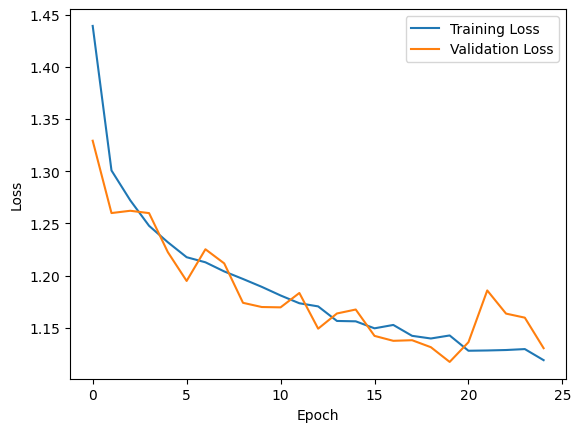

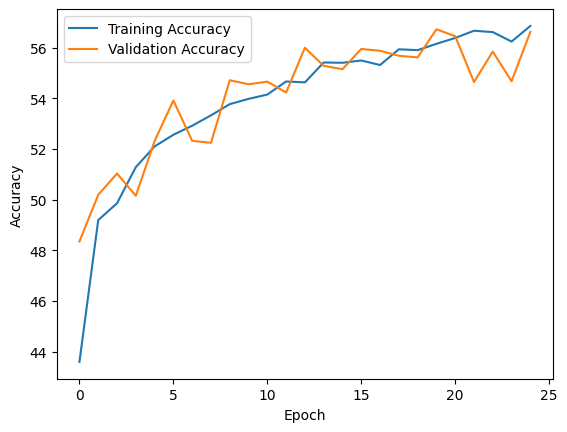

In [16]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=train_transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=test_transform)

trainloader = DataLoader(trainset, batch_size=128,
                         shuffle=True, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=128,
                        shuffle=False, num_workers=8, pin_memory=True)

# Label mappings
labelmap = trainset.label_map
print(f"Mapping from Emotion to Number: {labelmap}")

print(f"Model is on: {next(model.parameters()).device}")
model, train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(
    model, trainloader, testloader, criterion, optimizer, device, epochs)
torch.save(model.state_dict(), f'{FINETUNED_MODEL}_variables_{epochs}.pt')

# Plots
plot_loss(train_losses, test_losses)
plot_accuracy(train_accuracies, test_accuracies)

Plot confusion matrix


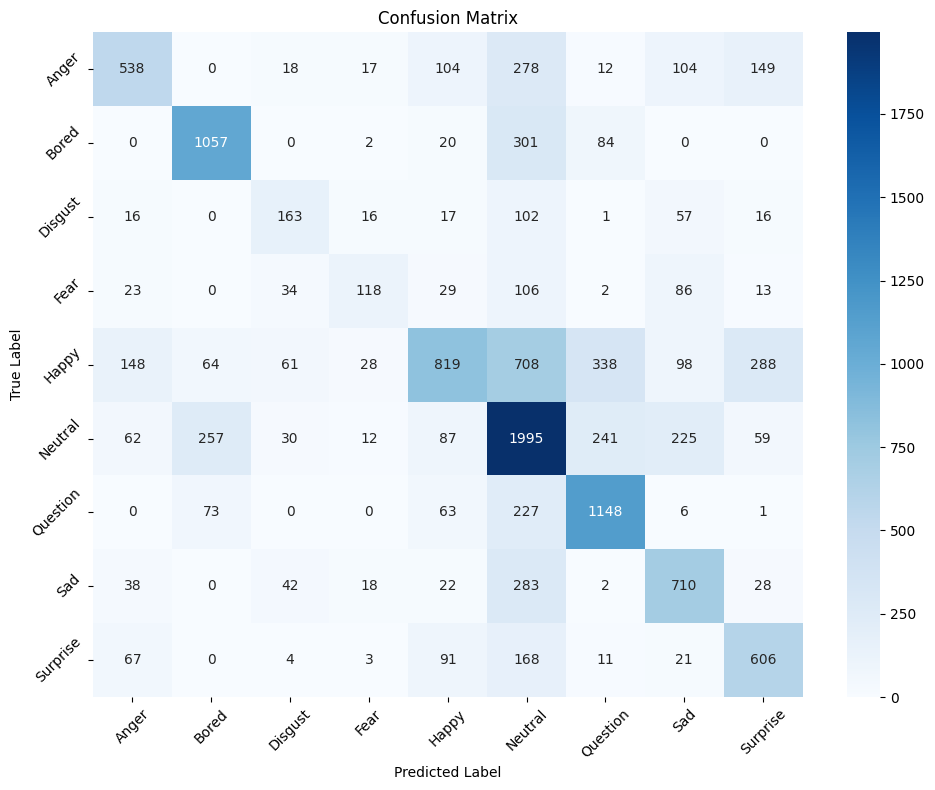

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(y_true, y_pred):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create figure and axes
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm,
                annot=True,  # Show numbers in cells
                fmt='d',     # Use integer formatting
                cmap='Blues',  # Color scheme
                xticklabels=trainset.label_map.keys(),
                yticklabels=trainset.label_map.keys())

    # Set labels and title
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Rotate axis labels for better readability
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.show()


# To use this function, collect predictions and true labels during testing
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot the confusion matrix
plot_confusion_matrix(all_labels, all_preds)